# Introduction to Xarray

![xarray Logo](https://docs.xarray.dev/en/stable/_static/Xarray_Logo_RGB_Final.svg "xarray Logo")


---

## Overview

The examples in this tutorial focus on the fundamentals of working with gridded, labeled data using Xarray {cite:p}`hoyer2017xarray`. Xarray works by introducing additional abstractions into otherwise ordinary data arrays. In this tutorial, we demonstrate the usefulness of these abstractions. The examples in this tutorial explain how the proper usage of Xarray abstractions generally leads to simpler, more robust code.

The following topics will be covered in this tutorial:

1. Create a <xref:xarray#generated/xarray.DataArray>, one of the core object types in Xarray
1. Understand how to use named coordinates and metadata in a `DataArray`
1. Combine individual `DataArrays` into a `Dataset`, the other core object type in Xarray
1. Subset, slice, and interpolate the data using named coordinates
1. Open netCDF data using Xarray
1. Basic subsetting and aggregation of a `Dataset`
1. Brief introduction to plotting with Xarray

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](../numpy/numpy-basics) | Necessary | {cite:t}`harris2020array` |
| [Intermediate NumPy](../numpy/intermediate-numpy) | Helpful | Familiarity with indexing and slicing arrays |
| [NumPy Broadcasting](../numpy/numpy-broadcasting) | Helpful | Familiarity with array arithmetic and broadcasting |
| [Introduction to Pandas](../pandas/pandas) | Helpful | Familiarity with labeled data |
| [Datetime](../datetime/datetime) | Helpful | Familiarity with time formats and the `timedelta` object |
| [Understanding of NetCDF](some-link-to-external-resource) | Helpful | Familiarity with metadata structure |

- **Time to learn**: 40 minutes

---

## Imports

In earlier tutorials, we explained the abbreviation of commonly used scientific Python package names in import statements. Just as `numpy` is abbreviated `np`, and just as `pandas` is abbreviated `pd`, the name `xarray` is often abbreviated `xr` in import statements. In addition, we also import `pythia_datasets`, which provides sample data used in these examples.

In [35]:
from datetime import timedelta

import numpy as np
import pandas as pd
import xarray as xr
import scipy
import netCDF4
import h5netcdf
import matplotlib
from pythia_datasets import DATASETS

## Introducing the `DataArray` and `Dataset`

As stated in earlier tutorials, NumPy arrays contain many useful features, making NumPy an essential part of the scientific Python stack.  Xarray expands on these features, adding streamlined data manipulation capabilities. These capabilities are similar to those provided by Pandas, except that they are focused on gridded N-dimensional data instead of tabular data. Its interface is based largely on the netCDF data model (variables, attributes, and dimensions), but it goes beyond the traditional netCDF interfaces in order to provide additional useful functionality, similar to netCDF-java's [Common Data Model (CDM)](https://docs.unidata.ucar.edu/netcdf-java/current/userguide/common_data_model_overview.html). 

### Creation of a `DataArray` object

The `DataArray` in one of the most basic elements of Xarray; a `DataArray` object is similar to a numpy `ndarray` object. (For more information, see the documentation [here](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataarray).) In addition to retaining most functionality from NumPy arrays, Xarray `DataArrays` provide two critical pieces of functionality:

1. Coordinate names and values are stored with the data, making slicing and indexing much more powerful.
2. Attributes, similar to those in netCDF files, can be stored in a container built into the `DataArray`.

In these examples, we create a NumPy array, and use it as a wrapper for a new `DataArray` object; we then explore some properties of a `DataArray`.

#### Generate a random numpy array

In this first example, we create a numpy array, holding random placeholder data of temperatures in Kelvin:

In [36]:
data = 283 + 5 * np.random.randn(5, 3, 4)
data

array([[[278.33806789, 280.44065756, 280.12034151, 276.64944216],
        [288.07955208, 282.37235689, 286.80658407, 286.22627989],
        [280.42117468, 274.57798557, 285.99861442, 280.99790694]],

       [[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
        [282.78218211, 287.33601299, 284.02635489, 275.37745778],
        [286.74500878, 289.82742092, 279.49216821, 275.02338063]],

       [[287.52429849, 278.14253243, 287.76379147, 287.53891462],
        [274.33791871, 286.77393122, 286.55684427, 282.35898233],
        [282.63774764, 292.36590423, 287.53231093, 277.89443141]],

       [[281.6458889 , 288.37737564, 285.1559592 , 279.9033899 ],
        [279.3038849 , 287.22626138, 275.53715017, 281.5290395 ],
        [275.61329312, 287.00661231, 282.56032888, 289.8487997 ]],

       [[283.14127714, 281.61986057, 278.99942378, 282.22445183],
        [284.47270213, 269.72968997, 290.126473  , 294.33154567],
        [277.76901239, 280.9297838 , 290.97343302, 277.64895196]]])

#### Wrap the array: first attempt

For our first attempt at wrapping a NumPy array into a `DataArray`, we simply use the `DataArray` method of Xarray, passing the NumPy array we just created:

In [37]:
temp = xr.DataArray(data)
temp

<xarray.DataArray (dim_0: 5, dim_1: 3, dim_2: 4)> Size: 480B
array([[[278.33806789, 280.44065756, 280.12034151, 276.64944216],
        [288.07955208, 282.37235689, 286.80658407, 286.22627989],
        [280.42117468, 274.57798557, 285.99861442, 280.99790694]],

       [[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
        [282.78218211, 287.33601299, 284.02635489, 275.37745778],
        [286.74500878, 289.82742092, 279.49216821, 275.02338063]],

       [[287.52429849, 278.14253243, 287.76379147, 287.53891462],
        [274.33791871, 286.77393122, 286.55684427, 282.35898233],
        [282.63774764, 292.36590423, 287.53231093, 277.89443141]],

       [[281.6458889 , 288.37737564, 285.1559592 , 279.9033899 ],
        [279.3038849 , 287.22626138, 275.53715017, 281.5290395 ],
        [275.61329312, 287.00661231, 282.56032888, 289.8487997 ]],

       [[283.14127714, 281.61986057, 278.99942378, 282.22445183],
        [284.47270213, 269.72968997, 290.126473  , 294.33154567],
        [277.76901239, 280.9297838 , 290.97343302, 277.64895196]]])
Dimensions without coordinates: dim_0, dim_1, dim_2

Note two things:

1. Since NumPy arrays have no dimension names, our new `DataArray` takes on placeholder dimension names, in this case `dim_0`, `dim_1`, and `dim_2`.  In our next example, we demonstrate how to add more meaningful dimension names.
2. If you are viewing this page as a Jupyter Notebook, running the above example generates a rich display of the data contained in our `DataArray`. This display comes with many ways to explore the data; for example, clicking the array symbol expands or collapses the data view.

#### Assign dimension names

Much of the power of Xarray comes from making use of named dimensions. In order to make full use of this, we need to provide more useful dimension names. We can generate these names when creating a `DataArray` by passing an ordered list of names to the `DataArray` method, using the keyword argument `dims`:

In [38]:
temp = xr.DataArray(data, dims=['time', 'lat', 'lon'])
temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[278.33806789, 280.44065756, 280.12034151, 276.64944216],
        [288.07955208, 282.37235689, 286.80658407, 286.22627989],
        [280.42117468, 274.57798557, 285.99861442, 280.99790694]],

       [[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
        [282.78218211, 287.33601299, 284.02635489, 275.37745778],
        [286.74500878, 289.82742092, 279.49216821, 275.02338063]],

       [[287.52429849, 278.14253243, 287.76379147, 287.53891462],
        [274.33791871, 286.77393122, 286.55684427, 282.35898233],
        [282.63774764, 292.36590423, 287.53231093, 277.89443141]],

       [[281.6458889 , 288.37737564, 285.1559592 , 279.9033899 ],
        [279.3038849 , 287.22626138, 275.53715017, 281.5290395 ],
        [275.61329312, 287.00661231, 282.56032888, 289.8487997 ]],

       [[283.14127714, 281.61986057, 278.99942378, 282.22445183],
        [284.47270213, 269.72968997, 290.126473  , 294.33154567],
        [277.76901239, 280.9297838 , 290.97343302, 277.64895196]]])
Dimensions without coordinates: time, lat, lon

This `DataArray` is already an improvement over a NumPy array; the `DataArray` contains names for each of the dimensions (or axes in NumPy parlance). An additional improvement is the association of coordinate-value arrays with data upon creation of a `DataArray`. In the next example, we illustrate the creation of NumPy arrays representing the coordinate values for each dimension of the `DataArray`, and how to associate these coordinate arrays with the data in our `DataArray`.

### Create a `DataArray` with named Coordinates

#### Make time and space coordinates

In this example, we use [Pandas](../pandas) to create an array of [datetime data](../datetime). This array will be used in a later example to add a named coordinate, called `time`, to a `DataArray`.

In [39]:
times = pd.date_range('2018-01-01', periods=5)
times

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq='D')

Before associating coordinates with our `DataArray`, we must also create latitude and longitude coordinate arrays.  In these examples, we use placeholder data, and create the arrays in NumPy format:

In [40]:
lons = np.linspace(-120, -60, 4)
lats = np.linspace(25, 55, 3)

#### Initialize the `DataArray` with complete coordinate info

In this example, we create a new `DataArray`. Similar to an earlier example, we use the `dims` keyword argument to specify the dimension names; however, in this case, we also specify the coordinate arrays using the `coords` keyword argument:

In [41]:
temp = xr.DataArray(data, coords=[times, lats, lons], dims=['time', 'lat', 'lon'])
temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[278.33806789, 280.44065756, 280.12034151, 276.64944216],
        [288.07955208, 282.37235689, 286.80658407, 286.22627989],
        [280.42117468, 274.57798557, 285.99861442, 280.99790694]],

       [[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
        [282.78218211, 287.33601299, 284.02635489, 275.37745778],
        [286.74500878, 289.82742092, 279.49216821, 275.02338063]],

       [[287.52429849, 278.14253243, 287.76379147, 287.53891462],
        [274.33791871, 286.77393122, 286.55684427, 282.35898233],
        [282.63774764, 292.36590423, 287.53231093, 277.89443141]],

       [[281.6458889 , 288.37737564, 285.1559592 , 279.9033899 ],
        [279.3038849 , 287.22626138, 275.53715017, 281.5290395 ],
        [275.61329312, 287.00661231, 282.56032888, 289.8487997 ]],

       [[283.14127714, 281.61986057, 278.99942378, 282.22445183],
        [284.47270213, 269.72968997, 290.126473  , 294.33154567],
        [277.76901239, 280.9297838 , 290.97343302, 277.64895196]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0

#### Set useful attributes

As described above, `DataArrays` have a built-in container for attribute metadata. These attributes are similar to those in netCDF files, and are added to a `DataArray` using its `attrs` method:

In [42]:
temp.attrs['units'] = 'kelvin'
temp.attrs['standard_name'] = 'air_temperature'

temp

<xarray.DataArray (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[278.33806789, 280.44065756, 280.12034151, 276.64944216],
        [288.07955208, 282.37235689, 286.80658407, 286.22627989],
        [280.42117468, 274.57798557, 285.99861442, 280.99790694]],

       [[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
        [282.78218211, 287.33601299, 284.02635489, 275.37745778],
        [286.74500878, 289.82742092, 279.49216821, 275.02338063]],

       [[287.52429849, 278.14253243, 287.76379147, 287.53891462],
        [274.33791871, 286.77393122, 286.55684427, 282.35898233],
        [282.63774764, 292.36590423, 287.53231093, 277.89443141]],

       [[281.6458889 , 288.37737564, 285.1559592 , 279.9033899 ],
        [279.3038849 , 287.22626138, 275.53715017, 281.5290395 ],
        [275.61329312, 287.00661231, 282.56032888, 289.8487997 ]],

       [[283.14127714, 281.61986057, 278.99942378, 282.22445183],
        [284.47270213, 269.72968997, 290.126473  , 294.33154567],
        [277.76901239, 280.9297838 , 290.97343302, 277.64895196]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

#### Issues with preservation of attributes

In this example, we illustrate an important concept relating to attributes. When a mathematical operation is performed on a `DataArray`, all of the coordinate arrays remain attached to the `DataArray`, but any attribute metadata assigned is lost. Attributes are removed in this way due to the fact that they may not convey correct or appropriate metadata after an arbitrary arithmetic operation.

This example converts our DataArray values from Kelvin to degrees Celsius. Pay attention to the attributes in the Jupyter rich display below. (If you are not viewing this page as a Jupyter notebook, see the Xarray documentation to learn how to display the attributes.)

In [43]:
temp_in_celsius = temp - 273.15
temp_in_celsius

<xarray.DataArray (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[ 5.18806789,  7.29065756,  6.97034151,  3.49944216],
        [14.92955208,  9.22235689, 13.65658407, 13.07627989],
        [ 7.27117468,  1.42798557, 12.84861442,  7.84790694]],

       [[16.63717544, 12.0569006 , 11.00101701,  4.52050222],
        [ 9.63218211, 14.18601299, 10.87635489,  2.22745778],
        [13.59500878, 16.67742092,  6.34216821,  1.87338063]],

       [[14.37429849,  4.99253243, 14.61379147, 14.38891462],
        [ 1.18791871, 13.62393122, 13.40684427,  9.20898233],
        [ 9.48774764, 19.21590423, 14.38231093,  4.74443141]],

       [[ 8.4958889 , 15.22737564, 12.0059592 ,  6.7533899 ],
        [ 6.1538849 , 14.07626138,  2.38715017,  8.3790395 ],
        [ 2.46329312, 13.85661231,  9.41032888, 16.6987997 ]],

       [[ 9.99127714,  8.46986057,  5.84942378,  9.07445183],
        [11.32270213, -3.42031003, 16.976473  , 21.18154567],
        [ 4.61901239,  7.7797838 , 17.82343302,  4.49895196]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0

In addition, if you need more details on how Xarray handles metadata, you can review this [documentation page](https://docs.xarray.dev/en/stable/get-help/faq.html#what-is-your-approach-to-metadata).

### The `Dataset`: a container for `DataArray`s with shared coordinates

Along with the `DataArray`, the other main object type in Xarray is the `Dataset`.  `Datasets` are containers similar to Python dictionaries; each `Dataset` can hold one or more `DataArrays`. In addition, the `DataArrays` contained in a `Dataset` can share coordinates, although this behavior is optional.  (For more information, see the [official documentation page](http://xarray.pydata.org/en/stable/user-guide/data-structures.html#dataset).)

`Dataset` objects are most often created by loading data from a data file. We will cover this functionality in a later example; in this example, we will create a `Dataset` from two `DataArrays`. We will use our existing temperature `DataArray` for one of these `DataArrays`; the other one is created in the next example.

In addition, both of these `DataArrays` will share coordinate axes. Therefore, the next example will also illustrate the usage of common coordinate axes across `DataArrays` in a `Dataset`.

#### Create a pressure `DataArray` using the same coordinates

In this example, we create a `DataArray` object to hold pressure data. This new `DataArray` is set up in a very similar fashion to the temperature `DataArray` created above.

In [44]:
pressure_data = 1000.0 + 5 * np.random.randn(5, 3, 4)
pressure = xr.DataArray(
    pressure_data, coords=[times, lats, lons], dims=['time', 'lat', 'lon']
)
pressure.attrs['units'] = 'hPa'
pressure.attrs['standard_name'] = 'air_pressure'

pressure

<xarray.DataArray (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[1002.535326  , 1009.04015581, 1001.96993794, 1008.26390606],
        [ 992.71275973, 1002.18944804,  996.97598513,  998.18621707],
        [ 998.99927259, 1009.35492953, 1003.35436406, 1001.34563819]],

       [[1000.03068054,  997.47175514,  999.06245423,  990.87984213],
        [ 998.53542427, 1002.88050071,  999.1267116 , 1005.32797379],
        [ 996.00070121, 1002.92260083,  997.12498412,  997.6336388 ]],

       [[ 996.80943457,  990.44826309, 1001.08044487, 1002.02471155],
        [ 999.6963706 ,  992.55724735,  999.13375065,  993.79621539],
        [ 998.50432138,  997.54573118,  989.20200015,  998.59689206]],

       [[ 982.59109651, 1000.35470943,  996.61087262, 1000.24065909],
        [1005.87045328,  996.74390332, 1007.42423486, 1001.44670646],
        [ 999.69206857,  998.46259986,  996.57101132, 1001.31135731]],

       [[ 999.57934604, 1005.67920423,  997.73557369, 1000.36350182],
        [1003.32605662, 1006.8205101 ,  995.24655232, 1006.38256526],
        [ 993.92827404, 1006.93607533,  985.92742466, 1002.33229713]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

#### Create a `Dataset` object

Before we can create a `Dataset` object, we must first name each of the `DataArray` objects that will be added to the new `Dataset`.

To name the `DataArrays` that will be added to our `Dataset`, we can set up a Python dictionary as shown in the next example. We can then pass this dictionary to the `Dataset` method using the keyword argument `data_vars`; this creates a new `Dataset` containing both of our `DataArrays`.

In [45]:
ds = xr.Dataset(data_vars={'Temperature': temp, 'Pressure': pressure})
ds

<xarray.Dataset> Size: 1kB
Dimensions:      (time: 5, lat: 3, lon: 4)
Coordinates:
  * time         (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat          (lat) float64 24B 25.0 40.0 55.0
  * lon          (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Data variables:
    Temperature  (time, lat, lon) float64 480B 278.3 280.4 280.1 ... 291.0 277.6
    Pressure     (time, lat, lon) float64 480B 1.003e+03 1.009e+03 ... 1.002e+03

As listed in the rich display above, the new `Dataset` object is aware that both `DataArrays` share the same coordinate axes. (Please note that if this page is not run as a Jupyter Notebook, the rich display may be unavailable.)

#### Access Data variables and Coordinates in a `Dataset`

This set of examples illustrates different methods for retrieving `DataArrays` from a `Dataset`.

This first example shows how to retrieve `DataArrays` using the "dot" notation:

In [46]:
ds.Pressure

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[1002.535326  , 1009.04015581, 1001.96993794, 1008.26390606],
        [ 992.71275973, 1002.18944804,  996.97598513,  998.18621707],
        [ 998.99927259, 1009.35492953, 1003.35436406, 1001.34563819]],

       [[1000.03068054,  997.47175514,  999.06245423,  990.87984213],
        [ 998.53542427, 1002.88050071,  999.1267116 , 1005.32797379],
        [ 996.00070121, 1002.92260083,  997.12498412,  997.6336388 ]],

       [[ 996.80943457,  990.44826309, 1001.08044487, 1002.02471155],
        [ 999.6963706 ,  992.55724735,  999.13375065,  993.79621539],
        [ 998.50432138,  997.54573118,  989.20200015,  998.59689206]],

       [[ 982.59109651, 1000.35470943,  996.61087262, 1000.24065909],
        [1005.87045328,  996.74390332, 1007.42423486, 1001.44670646],
        [ 999.69206857,  998.46259986,  996.57101132, 1001.31135731]],

       [[ 999.57934604, 1005.67920423,  997.73557369, 1000.36350182],
        [1003.32605662, 1006.8205101 ,  995.24655232, 1006.38256526],
        [ 993.92827404, 1006.93607533,  985.92742466, 1002.33229713]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

In addition, you can access `DataArrays` through a dictionary syntax, as shown in this example:

In [47]:
ds['Pressure']

<xarray.DataArray 'Pressure' (time: 5, lat: 3, lon: 4)> Size: 480B
array([[[1002.535326  , 1009.04015581, 1001.96993794, 1008.26390606],
        [ 992.71275973, 1002.18944804,  996.97598513,  998.18621707],
        [ 998.99927259, 1009.35492953, 1003.35436406, 1001.34563819]],

       [[1000.03068054,  997.47175514,  999.06245423,  990.87984213],
        [ 998.53542427, 1002.88050071,  999.1267116 , 1005.32797379],
        [ 996.00070121, 1002.92260083,  997.12498412,  997.6336388 ]],

       [[ 996.80943457,  990.44826309, 1001.08044487, 1002.02471155],
        [ 999.6963706 ,  992.55724735,  999.13375065,  993.79621539],
        [ 998.50432138,  997.54573118,  989.20200015,  998.59689206]],

       [[ 982.59109651, 1000.35470943,  996.61087262, 1000.24065909],
        [1005.87045328,  996.74390332, 1007.42423486, 1001.44670646],
        [ 999.69206857,  998.46259986,  996.57101132, 1001.31135731]],

       [[ 999.57934604, 1005.67920423,  997.73557369, 1000.36350182],
        [1003.32605662, 1006.8205101 ,  995.24655232, 1006.38256526],
        [ 993.92827404, 1006.93607533,  985.92742466, 1002.33229713]]])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          hPa
    standard_name:  air_pressure

`Dataset` objects are mainly used for loading data from files, which will be covered later in this tutorial.

## Subsetting and selection by coordinate values

Much of the power of labeled coordinates comes from the ability to select data based on coordinate names and values instead of array indices. This functionality will be covered on a basic level in these examples.  (Later tutorials will cover this topic in much greater detail.)

### NumPy-like selection

In these examples, we are trying to extract all of our spatial data for a single date; in this case, January 2, 2018. For our first example, we retrieve spatial data using index selection, as with a NumPy array:

In [48]:
indexed_selection = temp[1, :, :]  # Index 1 along axis 0 is the time slice we want...
indexed_selection

<xarray.DataArray (lat: 3, lon: 4)> Size: 96B
array([[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
       [282.78218211, 287.33601299, 284.02635489, 275.37745778],
       [286.74500878, 289.82742092, 279.49216821, 275.02338063]])
Coordinates:
    time     datetime64[ns] 8B 2018-01-02
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This example reveals one of the major shortcomings of index selection. In order to retrieve the correct data using index selection, anyone using a `DataArray` must have precise knowledge of the axes in the `DataArray`, including the order of the axes and the meaning of their indices.

By using named coordinates, as shown in the next set of examples, we can avoid this cumbersome burden.

### Selecting with `.sel()`

In this example, we show how to select data based on coordinate values, by way of the `.sel()` method. This method takes one or more named coordinates in keyword-argument format, and returns data matching the coordinates.

In [49]:
named_selection = temp.sel(time='2018-01-02')
named_selection

<xarray.DataArray (lat: 3, lon: 4)> Size: 96B
array([[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
       [282.78218211, 287.33601299, 284.02635489, 275.37745778],
       [286.74500878, 289.82742092, 279.49216821, 275.02338063]])
Coordinates:
    time     datetime64[ns] 8B 2018-01-02
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This method yields the same result as the index selection, however:
- we didn't have to know anything about how the array was created or stored
- our code is agnostic about how many dimensions we are dealing with
- the intended meaning of our code is much clearer

### Approximate selection and interpolation

When working with temporal and spatial data, it is a common practice to sample data close to the coordinate points in a dataset. The following set of examples illustrates some common techniques for this practice.

#### Nearest-neighbor sampling

In this example, we are trying to sample a temporal data point within 2 days of the date `2018-01-07`. Since the final date on our `DataArray`'s temporal axis is `2018-01-05`, this is an appropriate problem.

We can use the `.sel()` method to perform nearest-neighbor sampling, by setting the `method` keyword argument to 'nearest'. We can also optionally provide a `tolerance` argument; with temporal data, this is a `timedelta` object.

In [50]:
temp.sel(time='2018-01-07', method='nearest', tolerance=timedelta(days=2))

<xarray.DataArray (lat: 3, lon: 4)> Size: 96B
array([[283.14127714, 281.61986057, 278.99942378, 282.22445183],
       [284.47270213, 269.72968997, 290.126473  , 294.33154567],
       [277.76901239, 280.9297838 , 290.97343302, 277.64895196]])
Coordinates:
    time     datetime64[ns] 8B 2018-01-05
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

Using the rich display above, we can see that `.sel` indeed returned the data at the temporal value corresponding to the date `2018-01-05`.

#### Interpolation

In this example, we are trying to extract a timeseries for Boulder, CO, which is located at 40°N latitude and 105°W longitude. Our `DataArray` does not contain a longitude data value of -105, so in order to retrieve this timeseries, we must interpolate between data points.

The `.interp()` method allows us to retrieve data from any latitude and longitude by means of interpolation. This method uses coordinate-value selection, similarly to `.sel()`.  (For more information on the `.interp()` method, see the official documentation [here](http://xarray.pydata.org/en/stable/interpolation.html).)

In [51]:
temp.interp(lon=-105, lat=40)

<xarray.DataArray (time: 5)> Size: 40B
array([283.79915569, 286.19755527, 283.66492809, 285.24566726,
       273.41544301])
Coordinates:
  * time     (time) datetime64[ns] 40B 2018-01-01 2018-01-02 ... 2018-01-05
    lon      int64 8B -105
    lat      int64 8B 40
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    In order to interpolate data using Xarray, the SciPy package must be imported. You can learn more about SciPy from the <a href="https://scipy.org/">official documentation</a>.
</div>

### Slicing along coordinates

Frequently, it is useful to select a range, or _slice_, of data along one or more coordinates.  In order to understand this process, you must first understand Python `slice` objects. If you are unfamiliar with `slice` objects, you should first read the official [Python slice documentation](https://docs.python.org/3/library/functions.html#slice). Once you are proficient using `slice` objects, you can create slices of data by passing `slice` objects to the `.sel` method, as shown below:

In [52]:
temp.sel(
    time=slice('2018-01-01', '2018-01-03'), lon=slice(-110, -70), lat=slice(25, 45)
)

<xarray.DataArray (time: 3, lat: 2, lon: 2)> Size: 96B
array([[[280.44065756, 280.12034151],
        [282.37235689, 286.80658407]],

       [[285.2069006 , 284.15101701],
        [287.33601299, 284.02635489]],

       [[278.14253243, 287.76379147],
        [286.77393122, 286.55684427]]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 16B 25.0 40.0
  * lon      (lon) float64 16B -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    As detailed in the documentation page linked above, the <code>slice</code> function uses the argument order <code>(start, stop[, step])</code>, where <code>step</code> is optional.
</div>

Because we are now working with a slice of data, instead of our full dataset, the lengths of our coordinate axes have been shortened, as shown in the Jupyter rich display above. (You may need to use a different display technique if you are not running this page as a Jupyter Notebook.)

### One more selection method: `.loc`

In addition to using the `sel()` method to select data from a `DataArray`, you can also use the `.loc` attribute.  Every `DataArray` has a `.loc` attribute; in order to leverage this attribute to select data, you can specify a coordinate value in square brackets, as shown below:

In [53]:
temp.loc['2018-01-02']

<xarray.DataArray (lat: 3, lon: 4)> Size: 96B
array([[289.78717544, 285.2069006 , 284.15101701, 277.67050222],
       [282.78218211, 287.33601299, 284.02635489, 275.37745778],
       [286.74500878, 289.82742092, 279.49216821, 275.02338063]])
Coordinates:
    time     datetime64[ns] 8B 2018-01-02
  * lat      (lat) float64 24B 25.0 40.0 55.0
  * lon      (lon) float64 32B -120.0 -100.0 -80.0 -60.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

This selection technique is similar to NumPy's index-based selection, as shown below:
```
temp[1,:,:]
```
However, this technique also resembles the `.sel()` method's fully label-based selection functionality. The advantages and disadvantages of using the `.loc` attribute are discussed in detail below.

This example illustrates a significant disadvantage of using the `.loc` attribute.  Namely, we specify the values for each coordinate, but cannot specify the dimension names; therefore, the dimensions must be specified in the correct order, and this order must already be known:

In [54]:
temp.loc['2018-01-01':'2018-01-03', 25:45, -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)> Size: 96B
array([[[280.44065756, 280.12034151],
        [282.37235689, 286.80658407]],

       [[285.2069006 , 284.15101701],
        [287.33601299, 284.02635489]],

       [[278.14253243, 287.76379147],
        [286.77393122, 286.55684427]]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 16B 25.0 40.0
  * lon      (lon) float64 16B -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

In contrast with the previous example, this example shows a useful advantage of using the `.loc` attribute. When using the `.loc` attribute, you can specify data slices using a syntax similar to NumPy in addition to, or instead of, using the slice function.  Both of these slicing techniques are illustrated below:

In [55]:
temp.loc['2018-01-01':'2018-01-03', slice(25, 45), -110:-70]

<xarray.DataArray (time: 3, lat: 2, lon: 2)> Size: 96B
array([[[280.44065756, 280.12034151],
        [282.37235689, 286.80658407]],

       [[285.2069006 , 284.15101701],
        [287.33601299, 284.02635489]],

       [[278.14253243, 287.76379147],
        [286.77393122, 286.55684427]]])
Coordinates:
  * time     (time) datetime64[ns] 24B 2018-01-01 2018-01-02 2018-01-03
  * lat      (lat) float64 16B 25.0 40.0
  * lon      (lon) float64 16B -100.0 -80.0
Attributes:
    units:          kelvin
    standard_name:  air_temperature

As described above, the arguments to `.loc` must be in the order of the `DataArray`'s dimensions.  Attempting to slice data without ordering arguments properly can cause errors, as shown below:

In [56]:
# This will generate an error
# temp.loc[-110:-70, 25:45,'2018-01-01':'2018-01-03']

## Opening netCDF data

Xarray has close ties to the netCDF data format; as such, netCDF was chosen as the premier data file format for Xarray. Hence, Xarray can easily open netCDF datasets, provided they conform to certain limitations (for example, 1-dimensional coordinates).

### Access netCDF data with `xr.open_dataset`

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    The data file for this example, <code>NARR_19930313_0000.nc</code>, is retrieved from Project Pythia's custom example data library.  The <code>DATASETS</code> class imported at the top of this page contains a <code>.fetch()</code> method, which retrieves, downloads, and caches a Pythia example data file.
</div>

In [57]:
filepath = DATASETS.fetch('NARR_19930313_0000.nc')

Once we have a valid path to a data file that Xarray knows how to read, we can open the data file and load it into Xarray; this is done by passing the path to Xarray's `open_dataset` method, as shown below:

In [58]:
ds = xr.open_dataset(filepath)
ds

<xarray.Dataset> Size: 15MB
Dimensions:                       (time1: 1, isobaric1: 29, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 8B 1993-03-13
  * isobaric1                     (isobaric1) float32 116B 100.0 125.0 ... 1e+03
  * y                             (y) float32 476B -3.117e+03 ... 714.1
  * x                             (x) float32 1kB -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 4MB ...
    LambertConformal_Projection   int32 4B ...
    lat                           (y, x) float64 255kB ...
    lon                           (y, x) float64 255kB ...
    Geopotential_height_isobaric  (time1, isobaric1, y, x) float32 4MB ...
    v-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 4MB ...
    Temperature_isobaric          (time1, isobaric1, y, x) float32 4MB ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

### Subsetting the `Dataset`

Xarray's `open_dataset()` method, shown in the previous example, returns a `Dataset` object, which must then be assigned to a variable; in this case, we call the variable `ds`. Once the netCDF dataset is loaded into an Xarray `Dataset`, we can pull individual `DataArrays` out of the `Dataset`, using the technique described earlier in this tutorial.  In this example, we retrieve isobaric pressure data, as shown below:

In [59]:
ds.isobaric1

<xarray.DataArray 'isobaric1' (isobaric1: 29)> Size: 116B
array([ 100.,  125.,  150.,  175.,  200.,  225.,  250.,  275.,  300.,  350.,
        400.,  450.,  500.,  550.,  600.,  650.,  700.,  725.,  750.,  775.,
        800.,  825.,  850.,  875.,  900.,  925.,  950.,  975., 1000.],
      dtype=float32)
Coordinates:
  * isobaric1  (isobaric1) float32 116B 100.0 125.0 150.0 ... 950.0 975.0 1e+03
Attributes:
    units:                   hPa
    long_name:               Isobaric surface
    positive:                down
    Grib_level_type:         100
    _CoordinateAxisType:     Pressure
    _CoordinateZisPositive:  down

(As described earlier in this tutorial, we can also use dictionary syntax to select specific `DataArrays`; in this case, we would write `ds['isobaric1']`.)

Many of the subsetting operations usable on `DataArrays` can also be used on `Datasets`.  However, when used on `Datasets`, these operations are performed on every `DataArray` in the `Dataset`, as shown below:

In [60]:
ds_1000 = ds.sel(isobaric1=1000.0)
ds_1000

<xarray.Dataset> Size: 1MB
Dimensions:                       (time1: 1, y: 119, x: 268)
Coordinates:
  * time1                         (time1) datetime64[ns] 8B 1993-03-13
    isobaric1                     float32 4B 1e+03
  * y                             (y) float32 476B -3.117e+03 ... 714.1
  * x                             (x) float32 1kB -3.324e+03 ... 5.343e+03
Data variables:
    u-component_of_wind_isobaric  (time1, y, x) float32 128kB ...
    LambertConformal_Projection   int32 4B ...
    lat                           (y, x) float64 255kB ...
    lon                           (y, x) float64 255kB ...
    Geopotential_height_isobaric  (time1, y, x) float32 128kB ...
    v-component_of_wind_isobaric  (time1, y, x) float32 128kB ...
    Temperature_isobaric          (time1, y, x) float32 128kB ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North American Regional Reanalysis ...
    GRIB_table_version:                   0,131
    Generating_process_or_model:          North American Regional Reanalysis ...
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    History:                              Translated to CF-1.0 Conventions by...
    geospatial_lat_min:                   10.753308882144761
    geospatial_lat_max:                   46.8308828962289
    geospatial_lon_min:                   -153.88242040519995
    geospatial_lon_max:                   -42.666108129242815

As shown above, the subsetting operation performed on the `Dataset` returned a new `Dataset`.  If only a single `DataArray` is needed from this new `Dataset`, it can be retrieved using the familiar dot notation:

In [61]:
ds_1000.Temperature_isobaric

<xarray.DataArray 'Temperature_isobaric' (time1: 1, y: 119, x: 268)> Size: 128kB
[31892 values with dtype=float32]
Coordinates:
  * time1      (time1) datetime64[ns] 8B 1993-03-13
    isobaric1  float32 4B 1e+03
  * y          (y) float32 476B -3.117e+03 -3.084e+03 -3.052e+03 ... 681.6 714.1
  * x          (x) float32 1kB -3.324e+03 -3.292e+03 ... 5.311e+03 5.343e+03
Attributes:
    long_name:           Temperature @ Isobaric surface
    units:               K
    description:         Temperature
    grid_mapping:        LambertConformal_Projection
    Grib_Variable_Id:    VAR_7-15-131-11_L100
    Grib1_Center:        7
    Grib1_Subcenter:     15
    Grib1_TableVersion:  131
    Grib1_Parameter:     11
    Grib1_Level_Type:    100
    Grib1_Level_Desc:    Isobaric surface

### Aggregation operations

As covered earlier in this tutorial, you can use named dimensions in an Xarray `Dataset` to manually slice and index data.  However, these dimension names also serve an additional purpose: you can use them to specify dimensions to aggregate on.  There are many different aggregation operations available; in this example, we focus on `std` (standard deviation).

In [62]:
u_winds = ds['u-component_of_wind_isobaric']
u_winds.std(dim=['x', 'y'])

<xarray.DataArray 'u-component_of_wind_isobaric' (time1: 1, isobaric1: 29)> Size: 116B
array([[ 8.673963 , 10.212325 , 11.556413 , 12.254429 , 13.372146 ,
        15.472462 , 16.09197  , 15.846294 , 15.195835 , 13.936979 ,
        12.93888  , 12.060708 , 10.972139 ,  9.722328 ,  8.853287 ,
         8.257241 ,  7.6797214,  7.45165  ,  7.2352104,  7.039894 ,
         6.883371 ,  6.7821493,  6.7088237,  6.6865997,  6.7247376,
         6.7450233,  6.6859775,  6.5107226,  5.9722614]], dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 8B 1993-03-13
  * isobaric1  (isobaric1) float32 116B 100.0 125.0 150.0 ... 950.0 975.0 1e+03

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Info</p>
    Recall from previous tutorials that aggregations in NumPy operate over axes specified by numeric values. However, with Xarray objects, aggregation dimensions are instead specified through a list passed to the <code>dim</code> keyword argument.
</div>

For this set of examples, we will be using the sample dataset defined above.  The calculations performed in these examples compute the mean temperature profile, defined as temperature as a function of pressure, over Colorado.  For the purposes of these examples, the bounds of Colorado are defined as follows:
 * x: -182km to 424km
 * y: -1450km to -990km
    
This dataset uses a Lambert Conformal projection; therefore, the data values shown above are projected to specific latitude and longitude values.  In this example, these latitude and longitude values are 37°N to 41°N and 102°W to 109°W. Using the original data values and the `mean` aggregation function as shown below yields the following mean temperature profile data:

In [67]:
temps = ds.Temperature_isobaric
co_temps = temps.sel(x=slice(-182, 424), y=slice(-1450, -990))
prof = co_temps.mean(dim=['x', 'y'])
prof 

<xarray.DataArray 'Temperature_isobaric' (time1: 1, isobaric1: 29)> Size: 116B
array([[215.078  , 215.76935, 217.243  , 217.82663, 215.83487, 216.10933,
        219.99902, 224.66118, 228.80576, 234.88701, 238.78503, 242.66309,
        246.44807, 249.26636, 250.84995, 253.37354, 257.0429 , 259.08398,
        260.97955, 262.98364, 264.82138, 266.5198 , 268.22467, 269.7471 ,
        271.18216, 272.66815, 274.13037, 275.54718, 276.97675]],
      dtype=float32)
Coordinates:
  * time1      (time1) datetime64[ns] 8B 1993-03-13
  * isobaric1  (isobaric1) float32 116B 100.0 125.0 150.0 ... 950.0 975.0 1e+03

## Plotting with Xarray

As demonstrated earlier in this tutorial, there are many benefits to storing data as Xarray `DataArrays` and `Datasets`. In this section, we will cover another major benefit: Xarray greatly simplifies plotting of data stored as `DataArrays` and `Datasets`. One advantage of this is that many common plot elements, such as axis labels, are automatically generated and optimized for the data being plotted.  The next set of examples demonstrates this and provides a general overview of plotting with Xarray.

### Simple visualization with `.plot()`

Similarly to [Pandas](../pandas/pandas), Xarray includes a built-in plotting interface, which makes use of [Matplotlib](../matplotlib) behind the scenes. In order to use this interface, you can call the `.plot()` method, which is included in every `DataArray`.

In this example, we show how to create a basic plot from a `DataArray`. In this case, we are using the `prof` `DataArray` defined above, which contains a Colorado mean temperature profile.

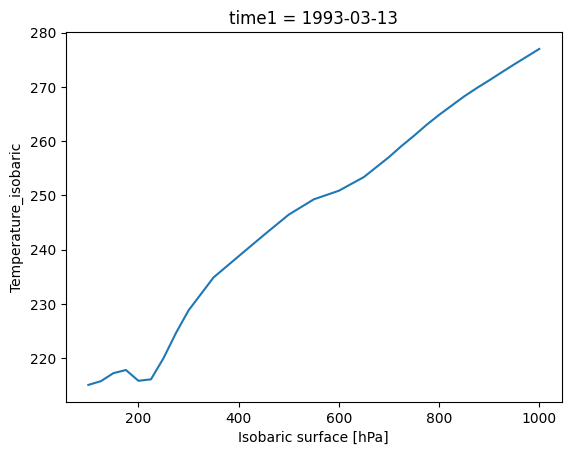

In [64]:
prof.plot()

In the figure shown above, Xarray has generated a line plot, which uses the mean temperature profile and the `'isobaric'` coordinate variable as axes. In addition, the axis labels and unit information have been read automatically from the `DataArray`'s metadata.

### Customizing the plot

As mentioned above, the `.plot()` method of Xarray `DataArrays` uses Matplotlib behind the scenes. Therefore, knowledge of Matplotlib can help you more easily customize plots generated by Xarray.

In this example, we need to customize the air temperature profile plot created above. There are two changes that need to be made:
- swap the axes, so that the Y (vertical) axis corresponds to isobaric levels
- invert the Y axis to match the model of air pressure decreasing at higher altitudes

We can make these changes by adding certain keyword arguments when calling `.plot()`, as shown below:

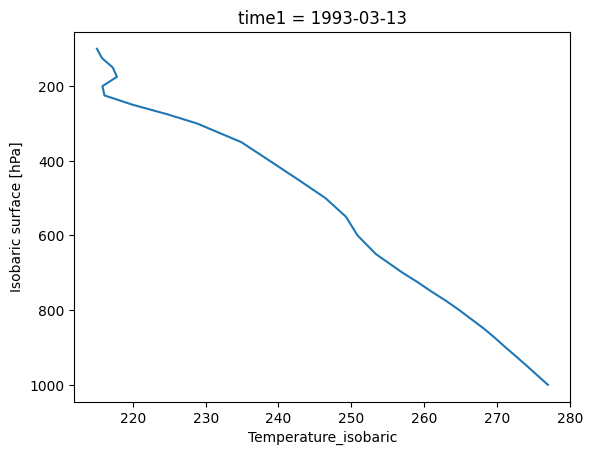

In [65]:
prof.plot(y="isobaric1", yincrease=False)

### Plotting 2-D data

In the previous example, we used `.plot()` to generate a plot from 1-D data, and the result was a line plot. In this section, we illustrate plotting of 2-D data.

In this example, we illustrate basic plotting of a 2-D array:

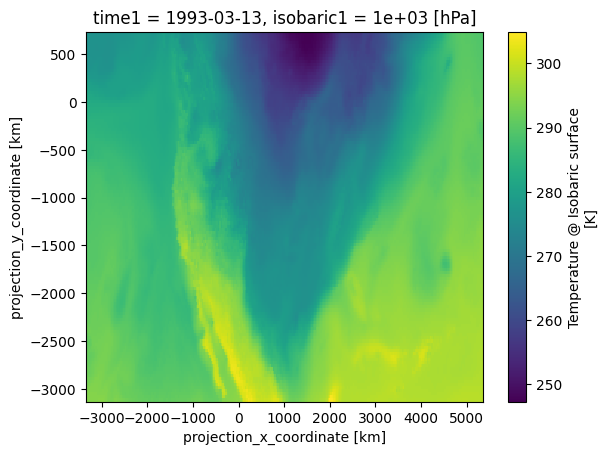

In [66]:
temps.sel(isobaric1=1000).plot()

The figure above is generated by Matplotlib's `pcolormesh` method, which was automatically called by Xarray's `plot` method.  This occurred because Xarray recognized that the `DataArray` object calling the `plot` method contained two distinct coordinate variables.

The plot generated by the above example is a map of air temperatures over North America, on the 1000 hPa isobaric surface. If a different map projection or added geographic features are needed on this plot, the plot can easily be modified using [Cartopy](../cartopy).

---

## Summary

Xarray expands on Pandas' labeled-data functionality, bringing the usefulness of labeled data operations to N-dimensional data. As such, it has become a central workhorse in the geoscience community for the analysis of gridded datasets. Xarray allows us to open self-describing NetCDF files and make full use of the coordinate axes, labels, units, and other metadata. By making use of labeled coordinates, our code is often easier to write, easier to read, and more robust.

### What's next?

Additional notebooks to appear in this section will describe the following topics in greater detail:
- performing arithmetic and broadcasting operations with Xarray data structures
- using "group by" operations
- remote data access with OPeNDAP
- more advanced visualization, including map integration with Cartopy

## Additional Resources

This tutorial contains content adapted from the material in [Unidata's Python Training](https://unidata.github.io/python-training/workshop/XArray/xarray-and-cf/).

Most basic questions and issues with Xarray can be resolved with help from the material in the [Xarray documentation](http://xarray.pydata.org/en/stable/). Some of the most popular sections of this documentation are listed below:
- [Why Xarray](http://xarray.pydata.org/en/stable/getting-started-guide/why-xarray.html)
- [Quick overview](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#)
- [Example gallery](http://xarray.pydata.org/en/stable/gallery.html)

Another resource you may find useful is this [Xarray Tutorial collection](https://xarray-contrib.github.io/xarray-tutorial/), created from content hosted on GitHub.

